In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from scipy.stats import t

In [3]:
def simulate_det_sir_model(beta, gamma, N, I0, R0, num_days):
    S, I, R = np.zeros(num_days), np.zeros(num_days), np.zeros(num_days)
    S[0] = N - I0 - R0
    I[0] = I0
    R[0] = R0

    for t in range(1, num_days):
        new_infections = beta * S[t-1] * I[t-1] / N
        new_recoveries = gamma * I[t-1]
        
        S[t] = S[t-1] - new_infections
        I[t] = I[t-1] + new_infections - new_recoveries
        R[t] = R[t-1] + new_recoveries
    return S, I, R

def simulate_stoc_sir_model(beta, gamma, N, I0, R0, num_days):
    S, I, R = np.zeros(num_days), np.zeros(num_days), np.zeros(num_days)
    S[0] = N - I0 - R0
    I[0] = I0
    R[0] = R0

    for t in range(1, num_days):
        new_infections = np.random.binomial(S[t-1], beta * I[t-1] / N)
        new_recoveries = np.random.binomial(I[t-1], gamma)

        S[t] = S[t-1] - new_infections
        I[t] = I[t-1] + new_infections - new_recoveries
        R[t] = R[t-1] + new_recoveries
    return S, I, R


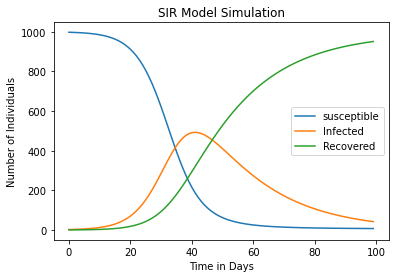

In [4]:
# Example usage:
beta = 0.25  # Infection rate
gamma = 1/20  # Recovery rate
population = 1000  # Total population size
initial_infected = 2  # Initial number of infected individuals
initial_recovered = 0  # Initial number of recovered individuals
num_days = 100  # Number of days to simulate

susceptible, infected, recovered = simulate_det_sir_model(beta, gamma, population, initial_infected, initial_recovered, num_days)
S,I,R = simulate_stoc_sir_model(beta, gamma, population, initial_infected, initial_recovered, num_days)

# Plotting the results
time = np.arange(num_days)
plt.plot(time, susceptible, label='susceptible')
plt.plot(time, infected, label='Infected')
plt.plot(time, recovered, label='Recovered')
plt.xlabel('Time in Days')
plt.ylabel('Number of Individuals')
plt.title('SIR Model Simulation')
plt.legend()
plt.show()

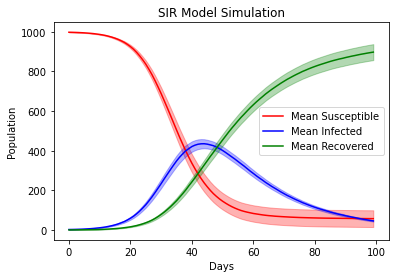

In [5]:
# Parameters
N = 1000  # Total population size
I0 = 2 # Initial number of infected individuals
R0 = 0  # Initial number of recovered individuals
beta = 0.25  # Infection rate
gamma = 1/20  # Recovery rate
num_days = 100

# makes 100 plots
num_simulations = 100

# Arrays to store simulation results
all_S = np.zeros((num_simulations, num_days))
all_I = np.zeros((num_simulations, num_days))
all_R = np.zeros((num_simulations, num_days))

# Run simulations
for i in range(num_simulations):
    # Simulate SIR model
    S, I, R = simulate_stoc_sir_model(beta, gamma, N, I0, R0, num_days)
    
    # Store results
    all_S[i] = S
    all_I[i] = I
    all_R[i] = R

# Calculate mean and confidence interval
mean_S = np.mean(all_S, axis=0)
mean_I = np.mean(all_I, axis=0)
mean_R = np.mean(all_R, axis=0)

std_S = np.std(all_S, axis=0)
std_I = np.std(all_I, axis=0)
std_R = np.std(all_R, axis=0)

lower_ci_S = mean_S - 1.96 * std_S / np.sqrt(num_simulations)
lower_ci_I = mean_I - 1.96 * std_I / np.sqrt(num_simulations)
lower_ci_R = mean_R - 1.96 * std_R / np.sqrt(num_simulations)

upper_ci_S = mean_S + 1.96 * std_S / np.sqrt(num_simulations)
upper_ci_I = mean_I + 1.96 * std_I / np.sqrt(num_simulations)
upper_ci_R = mean_R + 1.96 * std_R / np.sqrt(num_simulations)

# Plotting the mean and confidence interval
plt.plot(mean_S, label='Mean Susceptible', color='r')
plt.plot(mean_I, label='Mean Infected', color='b')
plt.plot(mean_R, label='Mean Recovered', color='g')

plt.fill_between(range(num_days), lower_ci_S, upper_ci_S, color='r', alpha=0.3)
plt.fill_between(range(num_days), lower_ci_I, upper_ci_I, color='b', alpha=0.3)
plt.fill_between(range(num_days), lower_ci_R, upper_ci_R, color='g', alpha=0.3)

plt.xlabel('Days')
plt.ylabel('Population')
plt.title('SIR Model Simulation')
plt.legend()
plt.show()

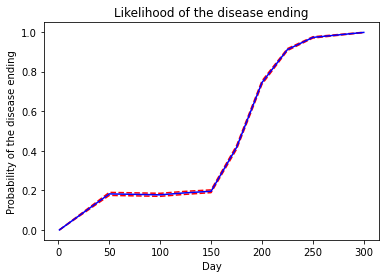

In [6]:
# Parameters
N = 1000  # Total population size
I0 = 1 # Initial number of infected individuals
R0 = 0  # Initial number of recovered individuals
beta = 0.25  # Infection rate
gamma = 1/20  # Recovery rate
num_days = 200

# calculating likelihood: 
def calclikehood(sim): 
    disap = 0
    for i in range(sim): 
        S, I, R = simulate_stoc_sir_model(beta, gamma, N, I0, R0, num_days)
        if I[-1] == 0:
            disap += 1
    likelihood = disap / sim
    return likelihood 

def get_likehoodlist(sim):
    likelihoodlist = []
    for i in range(sim): 
        likelihoodlist.append(calclikehood(sim))
    return likelihoodlist

def compute_confidence_interval(data, alpha=0.95):
    sample_mean = np.mean(data)
    sample_var  = np.var(data)
    sample_std = np.std(data, ddof=1)
    sample_size = len(data)
    t_value = t.ppf((1 + alpha) / 2, df=sample_size-1)
    margin_of_error = t_value * sample_std / np.sqrt(sample_size)
    confidence_interval = (sample_mean - margin_of_error, sample_mean + margin_of_error)
    return confidence_interval, sample_mean, sample_var

m = []
day = [1,50,100,125,150,175,200,225,250,300]
lower_ci = []
upper_ci = []

for i in day:
    num_days = i
    confidence_interval, mean, sample_var  = compute_confidence_interval(get_likehoodlist(100))
    m.append(mean)
    lower_ci.append(confidence_interval[0])
    upper_ci.append(confidence_interval[1])

# confidence interval
plt.plot(day,lower_ci, color='r', linestyle='dashed')
plt.plot(day,upper_ci,  color='r', linestyle='dashed')
#mean
plt.plot(day,m, color='b')
plt.title('Likelihood of the disease ending')
plt.xlabel('Day')
plt.ylabel('Probability of the disease ending')
plt.show()